In [2]:
%matplotlib inline
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/wisdm_individual_windows_20.p','rb'))
Fs = 20
window_size = 20
n_timesteps = window_size*Fs
X = X[:,:,:].reshape(-1,n_timesteps,3)
X = X/9.8
X[X<-2] = -2
X[X>2] = 2
X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X])
X_magnitude = X_magnitude.reshape(-1,n_timesteps,1)
import seaborn as sns
activity_list = ['Stationery','Stairs','Exercise','Walking','Sports']
y_activity = np.array([activity_list[a] for a in y_activity])

In [3]:
np.unique(y_activity)

array(['Exercise', 'Sports', 'Stairs', 'Stationery', 'Walking'],
      dtype='<U10')

In [5]:
X_d,y_hr_d,y_participant_d,y_activity_d,y_time_d = pickle.load(open('../data/dalia_individual_windows_20.p','rb'))
X_d = X_d[:,:,1:]*64

activity_dict_dalia = {0:'No Label',1:'Sitting', 2:'Stairs',3:'Soccer',
                4:'Cycling',5:'Driving',6:'Lunch',7:'Walking',
                8:'Working'}
activity_list = ['Stationery','Stairs','Exercise','Walking','Sports']
activity_dict_dalia_transformation = {0:-1,
                1:0,
                2:1,
                3:-1,
                4:2,
                5:0,
                6:-1,
                7:3,
                8:-1}
y_activity_d = np.array([activity_dict_dalia_transformation[a] for a in y_activity_d])
X_d  = X_d[y_activity_d>-1]
y_activity_d = y_activity_d[y_activity_d>-1]

from scipy.interpolate import interp1d
def interpolate_acl(a,window_size=20,fs_now=32,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)
X_new_d = np.array([interpolate_acl(a) for a in X_d])
Fs = 20
window_size = 20
n_timesteps = window_size*Fs
X = X[:,:,:].reshape(-1,n_timesteps,3)
X[X<-2] = -2
X[X>2] = 2
X_magnitude_d = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X_new_d]).reshape(-1,n_timesteps,1)
y_activity_d = np.array([activity_list[a] for a in y_activity_d])

In [6]:
np.unique(y_activity_d)

array(['Exercise', 'Stairs', 'Stationery', 'Walking'], dtype='<U10')

In [7]:
X = np.concatenate([X_magnitude,X_magnitude_d])
y_participant = np.array(list(y_participant)+list(y_participant_d+np.max(y_participant)+1))
y_activity = np.array(list(y_activity)+list(y_activity_d))

In [8]:
final_activity_dict = {a:i for i,a in enumerate(activity_list)}
final_activity_dict_reverse = {i:a for i,a in enumerate(activity_list)}

In [11]:
y_activity = np.array([final_activity_dict[a] for a in y_activity]) 

In [12]:
X.shape,y_activity.shape,y_participant.shape,len(np.unique(y_activity)),np.unique(y_activity)

((19614, 400, 1), (19614,), (36315,), 5, array([0, 1, 2, 3, 4]))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
# import numpy as np
# %matplotlib notebook
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input
from tensorflow.keras.models import Model, Sequential

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPU


In [14]:
def get_model(input_shape=(200,1),act='tanh',loss="mae",opt='adam',n_classes=1):
    model =  Sequential()
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(4))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes*20,activation='relu',kernel_initializer='normal'))
#     model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='embedding'))
    model.add(Dense(n_classes,activation=None,kernel_initializer='normal'))
    model.add(Dense(n_classes,activation='softmax',kernel_initializer='normal'))
    model.compile(loss=loss,optimizer=opt)
    return model
from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss
model =  get_model(input_shape=(n_timesteps,1),n_classes=len(np.unique(y_activity)),loss=SparseCategoricalFocalLoss(gamma=2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 400, 100)          1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 100)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 100)          400       
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 100)          0

In [15]:
from keras.models import load_model
n_classes = len(np.unique(y_activity))
model =  get_model(input_shape=(n_timesteps,1),n_classes=n_classes,loss=SparseCategoricalFocalLoss(gamma=1))
filepath = '../model_files/activity_estimator_both_study_magnitude_final_5_labels.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
train_x,test_x,train_y,test_y = train_test_split(X,y_activity,test_size=.3,stratify=y_activity)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=.2,stratify=train_y)
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=300, batch_size=50,verbose=1,
      callbacks=callbacks_list,shuffle=True)

Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
220/220 [==============================] - 7s 18ms/step - loss: 0.6095 - val_loss: 1.2847

Epoch 00001: val_loss improved from inf to 1.28472, saving model to ../model_files/activity_estimator_both_study_magnitude_final_5_labels.hdf5
Epoch 2/300
220/220 [==============================] - 3s 16ms/step - loss: 0.1930 - val_loss: 0.7213

Epoch 00002: val_loss improved from 1.28472 to 0.72130, saving model to ../model_files/activity_estimator_both_study_magnitude_final_5_labels.hdf5
Epoch 3/300
220/220 [==============================] - 3s 16ms/step - loss: 0.1453 - val_loss: 1.9738

Epoch 00003: val_loss did not improve from 0.72130
Epoch 4/300
220/220 [==============================] - 3s 16ms/step - loss: 0.1207 - val_loss: 0.3730

Epoch 00004: val_loss improved from 0.72130 to 0.37304, saving model to ../model_files/activity_estimator_bot

In [16]:
model.load_weights(filepath)

In [17]:
y_pred = model.predict(test_x).argmax(axis=1)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix

In [19]:
y_pred = [final_activity_dict_reverse[a] for a in y_pred]
test_y = [final_activity_dict_reverse[a] for a in test_y]

In [20]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

    Exercise       0.93      0.99      0.96       724
      Sports       0.95      0.93      0.94       941
      Stairs       0.94      0.96      0.95       698
  Stationery       0.97      0.97      0.97      2642
     Walking       0.98      0.94      0.96       880

    accuracy                           0.96      5885
   macro avg       0.96      0.96      0.96      5885
weighted avg       0.96      0.96      0.96      5885



In [22]:
import pandas as pd
df = pd.DataFrame({'original':test_y,'predicted':y_pred})
df['values'] = 1

In [23]:
data = pd.pivot_table(df,index='original',columns='predicted',values='values',aggfunc='sum')
data = data.fillna(0)
for a in np.unique(df['original']):
    data.loc[a] = data.loc[a]/data.loc[a].sum()
data

predicted,Exercise,Sports,Stairs,Stationery,Walking
original,,,,,
Exercise,0.988950,0.000000,0.001381,0.006906,0.002762
Sports,0.003188,0.933050,0.009564,0.053135,0.001063
Stairs,0.002865,0.020057,0.958453,0.001433,0.017192
Stationery,0.018168,0.009084,0.000379,0.970855,0.001514
Walking,0.000000,0.006818,0.032955,0.020455,0.939773


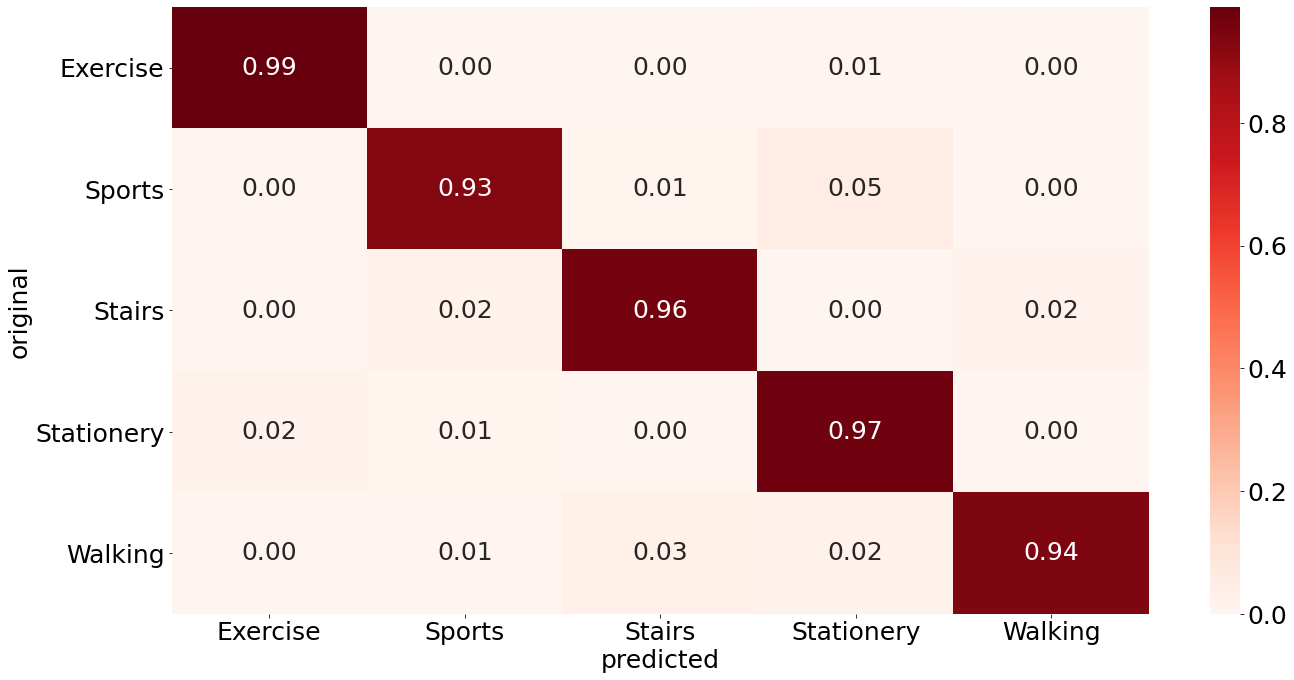

In [24]:
import seaborn as sns
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(20,10))
sns.heatmap(data,annot=True,fmt='.2f',cmap='Reds')
plt.tight_layout()
plt.savefig('./images/final_confusion_matrix_all.png')
plt.show()